In [1]:
import os
import csv
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import models # <-- THÊM THƯ VIỆN models
from torchvision.transforms import v2 as T
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, confusion_matrix)
import seaborn as sns
# from transformers import Wav2Vec2Model, logging as hf_logging # <-- Không cần nữa

# hf_logging.set_verbosity_error()


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Sử dụng thiết bị: {device}")

Sử dụng thiết bị: cuda


In [2]:
class TemporalAttentionAggregator(nn.Module):
    """
    Giữ nguyên lớp này để tổng hợp các đặc trưng từ MobileNetV2.
    """
    def __init__(self, in_channels, num_heads=8): # Tăng num_heads vì in_channels lớn hơn
        super().__init__()
        self.attention_net = nn.MultiheadAttention(embed_dim=in_channels, num_heads=num_heads, batch_first=True) # Thêm batch_first=True
        self.norm = nn.LayerNorm(in_channels)

    def forward(self, x):
        # x có shape (B, C, H, W) từ MobileNetV2
        B, C, H, W = x.size()
        x_flat = x.flatten(2).transpose(1, 2)  # (B, H*W, C)

        # Temporal-spatial attention
        x_norm = self.norm(x_flat)
        attn_output, _ = self.attention_net(x_norm, x_norm, x_norm) # Self-attention

        # Aggregate
        aggregated_vector = torch.mean(attn_output, dim=1)
        return aggregated_vector


In [3]:
class MobileNetV2_AudioClassifier(nn.Module):
    def __init__(self, num_classes, input_channels=1):
        super().__init__()
        # 1. Tải mô hình MobileNetV2 KHÔNG có trọng số pre-train
        # THAY ĐỔI CHÍNH LÀ Ở ĐÂY: weights=None
        mobilenet = models.mobilenet_v2(weights=None)

        # 2. Điều chỉnh lớp Conv đầu tiên để chấp nhận đầu vào 1 kênh (spectrogram)
        # Việc này vẫn cần thiết vì kiến trúc mặc định có 3 kênh đầu vào
        original_conv = mobilenet.features[0][0]
        new_first_conv = nn.Conv2d(
            in_channels=input_channels,
            out_channels=original_conv.out_channels,
            kernel_size=original_conv.kernel_size,
            stride=original_conv.stride,
            padding=original_conv.padding,
            bias=False
        )
        # Vì không có trọng số pre-train, lớp này sẽ được khởi tạo ngẫu nhiên
        mobilenet.features[0][0] = new_first_conv

        # 3. Sử dụng phần 'features' của MobileNetV2
        self.features = mobilenet.features

        # 4. Giữ lại lớp Aggregator của bạn
        self.aggregator = TemporalAttentionAggregator(in_channels=1280, num_heads=8)

        # 5. Lớp phân loại cuối cùng
        self.classifier = nn.Linear(1280, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = self.aggregator(x)
        x = self.classifier(x)
        return x

In [4]:
def count_parameters(model):
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total, trainable


In [5]:
class InsectSpectrogramDataset(Dataset):
    """Dataset tùy chỉnh để đọc các file spectrogram .pt"""
    def __init__(self, metadata_file, data_dir, transform=None):
        self.metadata = pd.read_csv(metadata_file)
        self.data_dir = data_dir
        self.transform = transform
        self.file_column = 'file_name'
        self.label_column = 'label'

        self.class_names = sorted(self.metadata[self.label_column].unique())
        self.class_to_id = {name: i for i, name in enumerate(self.class_names)}
        self.id_to_class = {i: name for name, i in self.class_to_id.items()}

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        file_name = self.metadata.iloc[idx][self.file_column]
        file_path = os.path.join(self.data_dir, file_name)
        label_name = self.metadata.iloc[idx][self.label_column]
        label = self.class_to_id[label_name]

        try:
            spectrogram = torch.load(file_path)
            if spectrogram.dim() == 2:
                spectrogram = spectrogram.unsqueeze(0)
            if self.transform:
                spectrogram = self.transform(spectrogram)
            return spectrogram, label
        except Exception as e:
            print(f"Lỗi khi tải file {file_path}: {e}")
            return torch.zeros(1, 128, 259), -1 # Trả về mẫu lỗi

In [6]:
METADATA_PATH = r'C:\Users\PC\Downloads\InsectSound1000_Mel\metadata_Mel.csv'
DATA_DIR = r'C:\Users\PC\Downloads\InsectSound1000_Mel\MelSpectrograms'

In [7]:
class TimeShift(torch.nn.Module):
    """ Dịch chuyển spectrogram theo trục thời gian một cách ngẫu nhiên. """
    def __init__(self, p=0.5, max_shift_percent=0.4):
        super().__init__()
        self.p = p
        self.max_shift_percent = max_shift_percent

    def forward(self, spec):
        if torch.rand(1) < self.p:
            time_steps = spec.shape[-1]
            shift_amount = int(torch.rand(1) * self.max_shift_percent * time_steps)
            if torch.rand(1) < 0.5:
                shift_amount = -shift_amount
            return torch.roll(spec, shifts=shift_amount, dims=-1)
        return spec

class SpecNoise(torch.nn.Module):
    """ Thêm nhiễu Gaussian trực tiếp vào spectrogram. """
    def __init__(self, p=0.5, noise_level=0.05):
        super().__init__()
        self.p = p
        self.noise_level = noise_level

    def forward(self, spec):
        if torch.rand(1) < self.p:
            noise = torch.randn_like(spec) * self.noise_level
            return spec + noise
        return spec

train_transform = T.Compose([
    torchaudio.transforms.TimeMasking(time_mask_param=80),
    torchaudio.transforms.FrequencyMasking(freq_mask_param=25),
    TimeShift(p=0.5, max_shift_percent=0.4),
    SpecNoise(p=0.3, noise_level=0.03),
])

val_transform = None

print("Đã định nghĩa xong pipeline Augmentation cho Spectrogram.")

def mixup_data(x, y, alpha=0.4, use_cuda=True):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(device if use_cuda else 'cpu')

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam


def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

Đã định nghĩa xong pipeline Augmentation cho Spectrogram.


In [8]:
if not os.path.exists(METADATA_PATH) or not os.path.isdir(DATA_DIR):
    print("!!! LỖI: Vui lòng kiểm tra lại đường dẫn METADATA_PATH và DATA_DIR.")
else:
    full_dataset = InsectSpectrogramDataset(METADATA_PATH, DATA_DIR)
    num_classes = len(full_dataset.class_names)
    print(f"Tải dữ liệu thành công: {len(full_dataset)} mẫu, {num_classes} lớp.")

    train_size = int(0.8 * len(full_dataset))
    val_size = len(full_dataset) - train_size
    generator = torch.Generator().manual_seed(42)
    train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size], generator)

    # Gán transform đúng cách cho đối tượng con của Subset
    train_dataset.dataset.transform = train_transform
    val_dataset.dataset.transform = val_transform

    BATCH_SIZE = 32
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)


Tải dữ liệu thành công: 165982 mẫu, 12 lớp.


In [10]:
EPOCHS = 100
LEARNING_RATE = 0.001 
WEIGHT_DECAY = 1e-4

CHECKPOINT_DIR = r'C:\Users\PC\Downloads\InsectSound1000_Mel\checkpoints_mobilenetV2'
LOG_CSV_PATH = r'C:\Users\PC\Downloads\InsectSound1000_Mel\training_log_mobilenetV2.csv'
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

In [11]:
model = MobileNetV2_AudioClassifier(num_classes=num_classes).to(device)
total_params, trainable_params = count_parameters(model)
print(f"Khởi tạo mô hình MobileNetV2 với {total_params/1e6:.2f}M tham số ({trainable_params/1e6:.2f}M có thể huấn luyện).")


criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

log_header = [
    'epoch', 'train_loss', 'val_loss', 'learning_rate',
    'accuracy', 'precision', 'recall', 'f1'
]
if not os.path.exists(LOG_CSV_PATH): # Chỉ ghi header nếu file chưa tồn tại
    with open(LOG_CSV_PATH, 'w', newline='', encoding='utf-8') as f:
        csv.writer(f).writerow(log_header)

print(f"\nBắt đầu huấn luyện... Checkpoints sẽ được lưu tại '{CHECKPOINT_DIR}' và log tại '{LOG_CSV_PATH}'")

best_val_f1 = 0.0

Khởi tạo mô hình MobileNetV2 với 8.80M tham số (8.80M có thể huấn luyện).

Bắt đầu huấn luyện... Checkpoints sẽ được lưu tại 'C:\Users\PC\Downloads\InsectSound1000_Mel\checkpoints_mobilenetV2' và log tại 'C:\Users\PC\Downloads\InsectSound1000_Mel\training_log_mobilenetV2.csv'


In [12]:
for epoch in range(EPOCHS):
    # ---- Train ----
    model.train()
    running_loss = 0.0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Training]")

    for inputs, labels in progress_bar:
        if -1 in labels:
            continue
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        if torch.rand(1).item() < 0.5:
            inputs, targets_a, targets_b, lam = mixup_data(inputs, labels, alpha=0.4, use_cuda=True)
            outputs = model(inputs)
            loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)
        else:
            outputs = model(inputs)
            loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        progress_bar.set_postfix(loss=f"{loss.item():.4f}")

    # ---- Validate ----
    model.eval()
    val_loss = 0.0
    val_preds, val_labels = [], []
    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Validation]"):
            if -1 in labels:
                continue
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)

            _, predicted = torch.max(outputs.data, 1)
            val_preds.extend(predicted.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())

    epoch_train_loss = running_loss / len(train_dataset)
    epoch_val_loss   = val_loss / len(val_dataset)

    accuracy  = accuracy_score(val_labels, val_preds)
    precision = precision_score(val_labels, val_preds, average='micro', zero_division=0)
    recall    = recall_score(val_labels, val_preds, average='micro', zero_division=0)
    f1        = f1_score(val_labels, val_preds, average='micro', zero_division=0)

    current_lr = scheduler.get_last_lr()[0]
    scheduler.step()

    print(f"\n--- Epoch {epoch+1}/{EPOCHS} Summary ---")
    print(f"  Train Loss: {epoch_train_loss:.4f} | Val Loss: {epoch_val_loss:.4f}")
    print(f"  Accuracy: {accuracy:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f} | F1: {f1:.4f}")
    print(f"  Learning Rate: {current_lr:.6f}")

    log_data = [epoch + 1, epoch_train_loss, epoch_val_loss, current_lr,
                accuracy, precision, recall, f1]
    with open(LOG_CSV_PATH, 'a', newline='', encoding='utf-8') as f:
        csv.writer(f).writerow(log_data)

    checkpoint_path = os.path.join(CHECKPOINT_DIR, f'checkpoint_epoch_{epoch+1}.pth')
    torch.save({
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }, checkpoint_path)

    if f1 > best_val_f1:
        best_val_f1 = f1
        best_model_path = os.path.join(CHECKPOINT_DIR, 'best_model.pth')
        torch.save(model.state_dict(), best_model_path)
        print(f"  => 🎉 New best model saved to '{best_model_path}' (F1: {best_val_f1:.4f})\n")

print("\n✅ Hoàn tất huấn luyện!")

Epoch 1/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 1/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 1/100 Summary ---
  Train Loss: 1.9520 | Val Loss: 1.8688
  Accuracy: 0.3264 | Precision: 0.3264 | Recall: 0.3264 | F1: 0.3264
  Learning Rate: 0.001000
  => 🎉 New best model saved to 'C:\Users\PC\Downloads\InsectSound1000_Mel\checkpoints_mobilenetV2\best_model.pth' (F1: 0.3264)



Epoch 2/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 2/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 2/100 Summary ---
  Train Loss: 2.0192 | Val Loss: 1.7940
  Accuracy: 0.3155 | Precision: 0.3155 | Recall: 0.3155 | F1: 0.3155
  Learning Rate: 0.001000


Epoch 3/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 3/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 3/100 Summary ---
  Train Loss: 1.9072 | Val Loss: 1.8734
  Accuracy: 0.3270 | Precision: 0.3270 | Recall: 0.3270 | F1: 0.3270
  Learning Rate: 0.000999
  => 🎉 New best model saved to 'C:\Users\PC\Downloads\InsectSound1000_Mel\checkpoints_mobilenetV2\best_model.pth' (F1: 0.3270)



Epoch 4/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 4/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 4/100 Summary ---
  Train Loss: 1.8248 | Val Loss: 1.5180
  Accuracy: 0.4413 | Precision: 0.4413 | Recall: 0.4413 | F1: 0.4413
  Learning Rate: 0.000998
  => 🎉 New best model saved to 'C:\Users\PC\Downloads\InsectSound1000_Mel\checkpoints_mobilenetV2\best_model.pth' (F1: 0.4413)



Epoch 5/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 5/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 5/100 Summary ---
  Train Loss: 1.4502 | Val Loss: 1.0859
  Accuracy: 0.5929 | Precision: 0.5929 | Recall: 0.5929 | F1: 0.5929
  Learning Rate: 0.000996
  => 🎉 New best model saved to 'C:\Users\PC\Downloads\InsectSound1000_Mel\checkpoints_mobilenetV2\best_model.pth' (F1: 0.5929)



Epoch 6/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 6/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 6/100 Summary ---
  Train Loss: 1.1723 | Val Loss: 0.9200
  Accuracy: 0.6810 | Precision: 0.6810 | Recall: 0.6810 | F1: 0.6810
  Learning Rate: 0.000994
  => 🎉 New best model saved to 'C:\Users\PC\Downloads\InsectSound1000_Mel\checkpoints_mobilenetV2\best_model.pth' (F1: 0.6810)



Epoch 7/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 7/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 7/100 Summary ---
  Train Loss: 0.9866 | Val Loss: 0.8243
  Accuracy: 0.7162 | Precision: 0.7162 | Recall: 0.7162 | F1: 0.7162
  Learning Rate: 0.000991
  => 🎉 New best model saved to 'C:\Users\PC\Downloads\InsectSound1000_Mel\checkpoints_mobilenetV2\best_model.pth' (F1: 0.7162)



Epoch 8/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 8/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 8/100 Summary ---
  Train Loss: 0.8784 | Val Loss: 0.6318
  Accuracy: 0.7763 | Precision: 0.7763 | Recall: 0.7763 | F1: 0.7763
  Learning Rate: 0.000988
  => 🎉 New best model saved to 'C:\Users\PC\Downloads\InsectSound1000_Mel\checkpoints_mobilenetV2\best_model.pth' (F1: 0.7763)



Epoch 9/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 9/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 9/100 Summary ---
  Train Loss: 0.8262 | Val Loss: 0.7644
  Accuracy: 0.7470 | Precision: 0.7470 | Recall: 0.7470 | F1: 0.7470
  Learning Rate: 0.000984


Epoch 10/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 10/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 10/100 Summary ---
  Train Loss: 0.7765 | Val Loss: 0.5757
  Accuracy: 0.8014 | Precision: 0.8014 | Recall: 0.8014 | F1: 0.8014
  Learning Rate: 0.000980
  => 🎉 New best model saved to 'C:\Users\PC\Downloads\InsectSound1000_Mel\checkpoints_mobilenetV2\best_model.pth' (F1: 0.8014)



Epoch 11/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 11/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 11/100 Summary ---
  Train Loss: 0.7417 | Val Loss: 0.5876
  Accuracy: 0.8018 | Precision: 0.8018 | Recall: 0.8018 | F1: 0.8018
  Learning Rate: 0.000976
  => 🎉 New best model saved to 'C:\Users\PC\Downloads\InsectSound1000_Mel\checkpoints_mobilenetV2\best_model.pth' (F1: 0.8018)



Epoch 12/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 12/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 12/100 Summary ---
  Train Loss: 0.7262 | Val Loss: 0.5305
  Accuracy: 0.8140 | Precision: 0.8140 | Recall: 0.8140 | F1: 0.8140
  Learning Rate: 0.000970
  => 🎉 New best model saved to 'C:\Users\PC\Downloads\InsectSound1000_Mel\checkpoints_mobilenetV2\best_model.pth' (F1: 0.8140)



Epoch 13/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 13/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 13/100 Summary ---
  Train Loss: 0.6997 | Val Loss: 0.5835
  Accuracy: 0.8084 | Precision: 0.8084 | Recall: 0.8084 | F1: 0.8084
  Learning Rate: 0.000965


Epoch 14/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 14/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 14/100 Summary ---
  Train Loss: 0.6906 | Val Loss: 0.4230
  Accuracy: 0.8544 | Precision: 0.8544 | Recall: 0.8544 | F1: 0.8544
  Learning Rate: 0.000959
  => 🎉 New best model saved to 'C:\Users\PC\Downloads\InsectSound1000_Mel\checkpoints_mobilenetV2\best_model.pth' (F1: 0.8544)



Epoch 15/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 15/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 15/100 Summary ---
  Train Loss: 0.6524 | Val Loss: 0.4646
  Accuracy: 0.8506 | Precision: 0.8506 | Recall: 0.8506 | F1: 0.8506
  Learning Rate: 0.000952


Epoch 16/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 16/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 16/100 Summary ---
  Train Loss: 0.6528 | Val Loss: 0.4391
  Accuracy: 0.8445 | Precision: 0.8445 | Recall: 0.8445 | F1: 0.8445
  Learning Rate: 0.000946


Epoch 17/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 17/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 17/100 Summary ---
  Train Loss: 0.6251 | Val Loss: 0.3980
  Accuracy: 0.8709 | Precision: 0.8709 | Recall: 0.8709 | F1: 0.8709
  Learning Rate: 0.000938
  => 🎉 New best model saved to 'C:\Users\PC\Downloads\InsectSound1000_Mel\checkpoints_mobilenetV2\best_model.pth' (F1: 0.8709)



Epoch 18/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 18/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 18/100 Summary ---
  Train Loss: 0.6162 | Val Loss: 0.3794
  Accuracy: 0.8762 | Precision: 0.8762 | Recall: 0.8762 | F1: 0.8762
  Learning Rate: 0.000930
  => 🎉 New best model saved to 'C:\Users\PC\Downloads\InsectSound1000_Mel\checkpoints_mobilenetV2\best_model.pth' (F1: 0.8762)



Epoch 19/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 19/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 19/100 Summary ---
  Train Loss: 0.6062 | Val Loss: 0.4175
  Accuracy: 0.8552 | Precision: 0.8552 | Recall: 0.8552 | F1: 0.8552
  Learning Rate: 0.000922


Epoch 20/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 20/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 20/100 Summary ---
  Train Loss: 0.5883 | Val Loss: 0.3786
  Accuracy: 0.8733 | Precision: 0.8733 | Recall: 0.8733 | F1: 0.8733
  Learning Rate: 0.000914


Epoch 21/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 21/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 21/100 Summary ---
  Train Loss: 0.5826 | Val Loss: 0.4317
  Accuracy: 0.8615 | Precision: 0.8615 | Recall: 0.8615 | F1: 0.8615
  Learning Rate: 0.000905


Epoch 22/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 22/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 22/100 Summary ---
  Train Loss: 0.5799 | Val Loss: 0.5170
  Accuracy: 0.8333 | Precision: 0.8333 | Recall: 0.8333 | F1: 0.8333
  Learning Rate: 0.000895


Epoch 23/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 23/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 23/100 Summary ---
  Train Loss: 0.5723 | Val Loss: 0.8246
  Accuracy: 0.7427 | Precision: 0.7427 | Recall: 0.7427 | F1: 0.7427
  Learning Rate: 0.000885


Epoch 24/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 24/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 24/100 Summary ---
  Train Loss: 0.5498 | Val Loss: 0.5642
  Accuracy: 0.8111 | Precision: 0.8111 | Recall: 0.8111 | F1: 0.8111
  Learning Rate: 0.000875


Epoch 25/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 25/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 25/100 Summary ---
  Train Loss: 0.5494 | Val Loss: 0.4062
  Accuracy: 0.8740 | Precision: 0.8740 | Recall: 0.8740 | F1: 0.8740
  Learning Rate: 0.000864


Epoch 26/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 26/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 26/100 Summary ---
  Train Loss: 0.5354 | Val Loss: 0.3230
  Accuracy: 0.8902 | Precision: 0.8902 | Recall: 0.8902 | F1: 0.8902
  Learning Rate: 0.000854
  => 🎉 New best model saved to 'C:\Users\PC\Downloads\InsectSound1000_Mel\checkpoints_mobilenetV2\best_model.pth' (F1: 0.8902)



Epoch 27/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 27/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 27/100 Summary ---
  Train Loss: 0.5361 | Val Loss: 0.3584
  Accuracy: 0.8844 | Precision: 0.8844 | Recall: 0.8844 | F1: 0.8844
  Learning Rate: 0.000842


Epoch 28/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 28/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 28/100 Summary ---
  Train Loss: 0.5230 | Val Loss: 0.3289
  Accuracy: 0.8906 | Precision: 0.8906 | Recall: 0.8906 | F1: 0.8906
  Learning Rate: 0.000831
  => 🎉 New best model saved to 'C:\Users\PC\Downloads\InsectSound1000_Mel\checkpoints_mobilenetV2\best_model.pth' (F1: 0.8906)



Epoch 29/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 29/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 29/100 Summary ---
  Train Loss: 0.5153 | Val Loss: 0.3161
  Accuracy: 0.8936 | Precision: 0.8936 | Recall: 0.8936 | F1: 0.8936
  Learning Rate: 0.000819
  => 🎉 New best model saved to 'C:\Users\PC\Downloads\InsectSound1000_Mel\checkpoints_mobilenetV2\best_model.pth' (F1: 0.8936)



Epoch 30/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 30/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 30/100 Summary ---
  Train Loss: 0.5024 | Val Loss: 0.3001
  Accuracy: 0.8969 | Precision: 0.8969 | Recall: 0.8969 | F1: 0.8969
  Learning Rate: 0.000806
  => 🎉 New best model saved to 'C:\Users\PC\Downloads\InsectSound1000_Mel\checkpoints_mobilenetV2\best_model.pth' (F1: 0.8969)



Epoch 31/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 31/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 31/100 Summary ---
  Train Loss: 0.4987 | Val Loss: 0.4954
  Accuracy: 0.8435 | Precision: 0.8435 | Recall: 0.8435 | F1: 0.8435
  Learning Rate: 0.000794


Epoch 32/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 32/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 32/100 Summary ---
  Train Loss: 0.4913 | Val Loss: 0.3565
  Accuracy: 0.8879 | Precision: 0.8879 | Recall: 0.8879 | F1: 0.8879
  Learning Rate: 0.000781


Epoch 33/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 33/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 33/100 Summary ---
  Train Loss: 0.4838 | Val Loss: 0.3000
  Accuracy: 0.9032 | Precision: 0.9032 | Recall: 0.9032 | F1: 0.9032
  Learning Rate: 0.000768
  => 🎉 New best model saved to 'C:\Users\PC\Downloads\InsectSound1000_Mel\checkpoints_mobilenetV2\best_model.pth' (F1: 0.9032)



Epoch 34/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 34/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 34/100 Summary ---
  Train Loss: 0.4824 | Val Loss: 0.3180
  Accuracy: 0.8944 | Precision: 0.8944 | Recall: 0.8944 | F1: 0.8944
  Learning Rate: 0.000755


Epoch 35/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 35/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 35/100 Summary ---
  Train Loss: 0.4849 | Val Loss: 0.3414
  Accuracy: 0.8991 | Precision: 0.8991 | Recall: 0.8991 | F1: 0.8991
  Learning Rate: 0.000741


Epoch 36/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 36/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 36/100 Summary ---
  Train Loss: 0.4677 | Val Loss: 0.2955
  Accuracy: 0.9017 | Precision: 0.9017 | Recall: 0.9017 | F1: 0.9017
  Learning Rate: 0.000727


Epoch 37/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 37/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 37/100 Summary ---
  Train Loss: 0.4553 | Val Loss: 0.3088
  Accuracy: 0.8972 | Precision: 0.8972 | Recall: 0.8972 | F1: 0.8972
  Learning Rate: 0.000713


Epoch 38/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 38/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 38/100 Summary ---
  Train Loss: 0.4621 | Val Loss: 0.3015
  Accuracy: 0.9000 | Precision: 0.9000 | Recall: 0.9000 | F1: 0.9000
  Learning Rate: 0.000699


Epoch 39/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 39/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 39/100 Summary ---
  Train Loss: 0.4477 | Val Loss: 0.3133
  Accuracy: 0.8978 | Precision: 0.8978 | Recall: 0.8978 | F1: 0.8978
  Learning Rate: 0.000684


Epoch 40/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 40/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 40/100 Summary ---
  Train Loss: 0.4542 | Val Loss: 0.2918
  Accuracy: 0.9044 | Precision: 0.9044 | Recall: 0.9044 | F1: 0.9044
  Learning Rate: 0.000669
  => 🎉 New best model saved to 'C:\Users\PC\Downloads\InsectSound1000_Mel\checkpoints_mobilenetV2\best_model.pth' (F1: 0.9044)



Epoch 41/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 41/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 41/100 Summary ---
  Train Loss: 0.4549 | Val Loss: 0.2924
  Accuracy: 0.9048 | Precision: 0.9048 | Recall: 0.9048 | F1: 0.9048
  Learning Rate: 0.000655
  => 🎉 New best model saved to 'C:\Users\PC\Downloads\InsectSound1000_Mel\checkpoints_mobilenetV2\best_model.pth' (F1: 0.9048)



Epoch 42/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 42/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 42/100 Summary ---
  Train Loss: 0.4245 | Val Loss: 0.2951
  Accuracy: 0.9037 | Precision: 0.9037 | Recall: 0.9037 | F1: 0.9037
  Learning Rate: 0.000639


Epoch 43/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 43/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 43/100 Summary ---
  Train Loss: 0.4386 | Val Loss: 0.3350
  Accuracy: 0.8900 | Precision: 0.8900 | Recall: 0.8900 | F1: 0.8900
  Learning Rate: 0.000624


Epoch 44/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 44/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 44/100 Summary ---
  Train Loss: 0.4243 | Val Loss: 0.3300
  Accuracy: 0.8974 | Precision: 0.8974 | Recall: 0.8974 | F1: 0.8974
  Learning Rate: 0.000609


Epoch 45/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 45/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 45/100 Summary ---
  Train Loss: 0.4207 | Val Loss: 0.3065
  Accuracy: 0.9039 | Precision: 0.9039 | Recall: 0.9039 | F1: 0.9039
  Learning Rate: 0.000594


Epoch 46/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 46/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 46/100 Summary ---
  Train Loss: 0.4189 | Val Loss: 0.3006
  Accuracy: 0.9063 | Precision: 0.9063 | Recall: 0.9063 | F1: 0.9063
  Learning Rate: 0.000578
  => 🎉 New best model saved to 'C:\Users\PC\Downloads\InsectSound1000_Mel\checkpoints_mobilenetV2\best_model.pth' (F1: 0.9063)



Epoch 47/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 47/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 47/100 Summary ---
  Train Loss: 0.4113 | Val Loss: 0.3374
  Accuracy: 0.8966 | Precision: 0.8966 | Recall: 0.8966 | F1: 0.8966
  Learning Rate: 0.000563


Epoch 48/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 48/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 48/100 Summary ---
  Train Loss: 0.3966 | Val Loss: 0.3099
  Accuracy: 0.9032 | Precision: 0.9032 | Recall: 0.9032 | F1: 0.9032
  Learning Rate: 0.000547


Epoch 49/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 49/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 49/100 Summary ---
  Train Loss: 0.3938 | Val Loss: 0.3244
  Accuracy: 0.8989 | Precision: 0.8989 | Recall: 0.8989 | F1: 0.8989
  Learning Rate: 0.000531


Epoch 50/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 50/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 50/100 Summary ---
  Train Loss: 0.3824 | Val Loss: 0.3502
  Accuracy: 0.8922 | Precision: 0.8922 | Recall: 0.8922 | F1: 0.8922
  Learning Rate: 0.000516


Epoch 51/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 51/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 51/100 Summary ---
  Train Loss: 0.3821 | Val Loss: 0.3824
  Accuracy: 0.8804 | Precision: 0.8804 | Recall: 0.8804 | F1: 0.8804
  Learning Rate: 0.000500


Epoch 52/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 52/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 52/100 Summary ---
  Train Loss: 0.3943 | Val Loss: 0.3419
  Accuracy: 0.8972 | Precision: 0.8972 | Recall: 0.8972 | F1: 0.8972
  Learning Rate: 0.000484


Epoch 53/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 53/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 53/100 Summary ---
  Train Loss: 0.3716 | Val Loss: 0.2908
  Accuracy: 0.9080 | Precision: 0.9080 | Recall: 0.9080 | F1: 0.9080
  Learning Rate: 0.000469
  => 🎉 New best model saved to 'C:\Users\PC\Downloads\InsectSound1000_Mel\checkpoints_mobilenetV2\best_model.pth' (F1: 0.9080)



Epoch 54/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 54/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 54/100 Summary ---
  Train Loss: 0.3811 | Val Loss: 0.3151
  Accuracy: 0.9037 | Precision: 0.9037 | Recall: 0.9037 | F1: 0.9037
  Learning Rate: 0.000453


Epoch 55/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 55/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 55/100 Summary ---
  Train Loss: 0.3901 | Val Loss: 0.2920
  Accuracy: 0.9098 | Precision: 0.9098 | Recall: 0.9098 | F1: 0.9098
  Learning Rate: 0.000437
  => 🎉 New best model saved to 'C:\Users\PC\Downloads\InsectSound1000_Mel\checkpoints_mobilenetV2\best_model.pth' (F1: 0.9098)



Epoch 56/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 56/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 56/100 Summary ---
  Train Loss: 0.3804 | Val Loss: 0.3364
  Accuracy: 0.9021 | Precision: 0.9021 | Recall: 0.9021 | F1: 0.9021
  Learning Rate: 0.000422


Epoch 57/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 57/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 57/100 Summary ---
  Train Loss: 0.3827 | Val Loss: 0.3412
  Accuracy: 0.8985 | Precision: 0.8985 | Recall: 0.8985 | F1: 0.8985
  Learning Rate: 0.000406


Epoch 58/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 58/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 58/100 Summary ---
  Train Loss: 0.3683 | Val Loss: 0.2972
  Accuracy: 0.9086 | Precision: 0.9086 | Recall: 0.9086 | F1: 0.9086
  Learning Rate: 0.000391


Epoch 59/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 59/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 59/100 Summary ---
  Train Loss: 0.3651 | Val Loss: 0.2921
  Accuracy: 0.9120 | Precision: 0.9120 | Recall: 0.9120 | F1: 0.9120
  Learning Rate: 0.000376
  => 🎉 New best model saved to 'C:\Users\PC\Downloads\InsectSound1000_Mel\checkpoints_mobilenetV2\best_model.pth' (F1: 0.9120)



Epoch 60/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 60/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 60/100 Summary ---
  Train Loss: 0.3505 | Val Loss: 0.2875
  Accuracy: 0.9128 | Precision: 0.9128 | Recall: 0.9128 | F1: 0.9128
  Learning Rate: 0.000361
  => 🎉 New best model saved to 'C:\Users\PC\Downloads\InsectSound1000_Mel\checkpoints_mobilenetV2\best_model.pth' (F1: 0.9128)



Epoch 61/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 61/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 61/100 Summary ---
  Train Loss: 0.3437 | Val Loss: 0.3055
  Accuracy: 0.9084 | Precision: 0.9084 | Recall: 0.9084 | F1: 0.9084
  Learning Rate: 0.000345


Epoch 62/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 62/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 62/100 Summary ---
  Train Loss: 0.3530 | Val Loss: 0.3141
  Accuracy: 0.9083 | Precision: 0.9083 | Recall: 0.9083 | F1: 0.9083
  Learning Rate: 0.000331


Epoch 63/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 63/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 63/100 Summary ---
  Train Loss: 0.3610 | Val Loss: 0.3519
  Accuracy: 0.8971 | Precision: 0.8971 | Recall: 0.8971 | F1: 0.8971
  Learning Rate: 0.000316


Epoch 64/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 64/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 64/100 Summary ---
  Train Loss: 0.3541 | Val Loss: 0.2971
  Accuracy: 0.9120 | Precision: 0.9120 | Recall: 0.9120 | F1: 0.9120
  Learning Rate: 0.000301


Epoch 65/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 65/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 65/100 Summary ---
  Train Loss: 0.3494 | Val Loss: 0.3172
  Accuracy: 0.9053 | Precision: 0.9053 | Recall: 0.9053 | F1: 0.9053
  Learning Rate: 0.000287


Epoch 66/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 66/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 66/100 Summary ---
  Train Loss: 0.3481 | Val Loss: 0.3322
  Accuracy: 0.9038 | Precision: 0.9038 | Recall: 0.9038 | F1: 0.9038
  Learning Rate: 0.000273


Epoch 67/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 67/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 67/100 Summary ---
  Train Loss: 0.3404 | Val Loss: 0.3109
  Accuracy: 0.9097 | Precision: 0.9097 | Recall: 0.9097 | F1: 0.9097
  Learning Rate: 0.000259


Epoch 68/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 68/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 68/100 Summary ---
  Train Loss: 0.3433 | Val Loss: 0.3069
  Accuracy: 0.9096 | Precision: 0.9096 | Recall: 0.9096 | F1: 0.9096
  Learning Rate: 0.000245


Epoch 69/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 69/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 69/100 Summary ---
  Train Loss: 0.3421 | Val Loss: 0.3105
  Accuracy: 0.9102 | Precision: 0.9102 | Recall: 0.9102 | F1: 0.9102
  Learning Rate: 0.000232


Epoch 70/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 70/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 70/100 Summary ---
  Train Loss: 0.3315 | Val Loss: 0.3257
  Accuracy: 0.9069 | Precision: 0.9069 | Recall: 0.9069 | F1: 0.9069
  Learning Rate: 0.000219


Epoch 71/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 71/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 71/100 Summary ---
  Train Loss: 0.3329 | Val Loss: 0.3231
  Accuracy: 0.9063 | Precision: 0.9063 | Recall: 0.9063 | F1: 0.9063
  Learning Rate: 0.000206


Epoch 72/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 72/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 72/100 Summary ---
  Train Loss: 0.3420 | Val Loss: 0.3223
  Accuracy: 0.9141 | Precision: 0.9141 | Recall: 0.9141 | F1: 0.9141
  Learning Rate: 0.000194
  => 🎉 New best model saved to 'C:\Users\PC\Downloads\InsectSound1000_Mel\checkpoints_mobilenetV2\best_model.pth' (F1: 0.9141)



Epoch 73/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 73/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 73/100 Summary ---
  Train Loss: 0.3275 | Val Loss: 0.3067
  Accuracy: 0.9141 | Precision: 0.9141 | Recall: 0.9141 | F1: 0.9141
  Learning Rate: 0.000181


Epoch 74/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 74/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 74/100 Summary ---
  Train Loss: 0.3211 | Val Loss: 0.3386
  Accuracy: 0.9094 | Precision: 0.9094 | Recall: 0.9094 | F1: 0.9094
  Learning Rate: 0.000169


Epoch 75/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 75/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 75/100 Summary ---
  Train Loss: 0.3298 | Val Loss: 0.3266
  Accuracy: 0.9088 | Precision: 0.9088 | Recall: 0.9088 | F1: 0.9088
  Learning Rate: 0.000158


Epoch 76/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 76/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 76/100 Summary ---
  Train Loss: 0.3263 | Val Loss: 0.3243
  Accuracy: 0.9091 | Precision: 0.9091 | Recall: 0.9091 | F1: 0.9091
  Learning Rate: 0.000146


Epoch 77/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 77/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 77/100 Summary ---
  Train Loss: 0.3153 | Val Loss: 0.3138
  Accuracy: 0.9157 | Precision: 0.9157 | Recall: 0.9157 | F1: 0.9157
  Learning Rate: 0.000136
  => 🎉 New best model saved to 'C:\Users\PC\Downloads\InsectSound1000_Mel\checkpoints_mobilenetV2\best_model.pth' (F1: 0.9157)



Epoch 78/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 78/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 78/100 Summary ---
  Train Loss: 0.3189 | Val Loss: 0.3254
  Accuracy: 0.9083 | Precision: 0.9083 | Recall: 0.9083 | F1: 0.9083
  Learning Rate: 0.000125


Epoch 79/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 79/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 79/100 Summary ---
  Train Loss: 0.3186 | Val Loss: 0.3125
  Accuracy: 0.9154 | Precision: 0.9154 | Recall: 0.9154 | F1: 0.9154
  Learning Rate: 0.000115


Epoch 80/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 80/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 80/100 Summary ---
  Train Loss: 0.3193 | Val Loss: 0.3264
  Accuracy: 0.9103 | Precision: 0.9103 | Recall: 0.9103 | F1: 0.9103
  Learning Rate: 0.000105


Epoch 81/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 81/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 81/100 Summary ---
  Train Loss: 0.3063 | Val Loss: 0.3144
  Accuracy: 0.9140 | Precision: 0.9140 | Recall: 0.9140 | F1: 0.9140
  Learning Rate: 0.000095


Epoch 82/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 82/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 82/100 Summary ---
  Train Loss: 0.3067 | Val Loss: 0.3124
  Accuracy: 0.9151 | Precision: 0.9151 | Recall: 0.9151 | F1: 0.9151
  Learning Rate: 0.000086


Epoch 83/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 83/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 83/100 Summary ---
  Train Loss: 0.3184 | Val Loss: 0.3176
  Accuracy: 0.9130 | Precision: 0.9130 | Recall: 0.9130 | F1: 0.9130
  Learning Rate: 0.000078


Epoch 84/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 84/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 84/100 Summary ---
  Train Loss: 0.3092 | Val Loss: 0.3145
  Accuracy: 0.9131 | Precision: 0.9131 | Recall: 0.9131 | F1: 0.9131
  Learning Rate: 0.000070


Epoch 85/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 85/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 85/100 Summary ---
  Train Loss: 0.3264 | Val Loss: 0.3188
  Accuracy: 0.9149 | Precision: 0.9149 | Recall: 0.9149 | F1: 0.9149
  Learning Rate: 0.000062


Epoch 86/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 86/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 86/100 Summary ---
  Train Loss: 0.3115 | Val Loss: 0.3107
  Accuracy: 0.9141 | Precision: 0.9141 | Recall: 0.9141 | F1: 0.9141
  Learning Rate: 0.000054


Epoch 87/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 87/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 87/100 Summary ---
  Train Loss: 0.3141 | Val Loss: 0.3238
  Accuracy: 0.9158 | Precision: 0.9158 | Recall: 0.9158 | F1: 0.9158
  Learning Rate: 0.000048
  => 🎉 New best model saved to 'C:\Users\PC\Downloads\InsectSound1000_Mel\checkpoints_mobilenetV2\best_model.pth' (F1: 0.9158)



Epoch 88/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 88/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 88/100 Summary ---
  Train Loss: 0.3153 | Val Loss: 0.3137
  Accuracy: 0.9159 | Precision: 0.9159 | Recall: 0.9159 | F1: 0.9159
  Learning Rate: 0.000041
  => 🎉 New best model saved to 'C:\Users\PC\Downloads\InsectSound1000_Mel\checkpoints_mobilenetV2\best_model.pth' (F1: 0.9159)



Epoch 89/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 89/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 89/100 Summary ---
  Train Loss: 0.3133 | Val Loss: 0.3097
  Accuracy: 0.9169 | Precision: 0.9169 | Recall: 0.9169 | F1: 0.9169
  Learning Rate: 0.000035
  => 🎉 New best model saved to 'C:\Users\PC\Downloads\InsectSound1000_Mel\checkpoints_mobilenetV2\best_model.pth' (F1: 0.9169)



Epoch 90/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 90/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 90/100 Summary ---
  Train Loss: 0.3268 | Val Loss: 0.3126
  Accuracy: 0.9172 | Precision: 0.9172 | Recall: 0.9172 | F1: 0.9172
  Learning Rate: 0.000030
  => 🎉 New best model saved to 'C:\Users\PC\Downloads\InsectSound1000_Mel\checkpoints_mobilenetV2\best_model.pth' (F1: 0.9172)



Epoch 91/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 91/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 91/100 Summary ---
  Train Loss: 0.3149 | Val Loss: 0.3567
  Accuracy: 0.9161 | Precision: 0.9161 | Recall: 0.9161 | F1: 0.9161
  Learning Rate: 0.000024


Epoch 92/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 92/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 92/100 Summary ---
  Train Loss: 0.3139 | Val Loss: 0.3172
  Accuracy: 0.9163 | Precision: 0.9163 | Recall: 0.9163 | F1: 0.9163
  Learning Rate: 0.000020


Epoch 93/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 93/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 93/100 Summary ---
  Train Loss: 0.3152 | Val Loss: 0.3236
  Accuracy: 0.9185 | Precision: 0.9185 | Recall: 0.9185 | F1: 0.9185
  Learning Rate: 0.000016
  => 🎉 New best model saved to 'C:\Users\PC\Downloads\InsectSound1000_Mel\checkpoints_mobilenetV2\best_model.pth' (F1: 0.9185)



Epoch 94/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 94/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 94/100 Summary ---
  Train Loss: 0.3179 | Val Loss: 0.3161
  Accuracy: 0.9147 | Precision: 0.9147 | Recall: 0.9147 | F1: 0.9147
  Learning Rate: 0.000012


Epoch 95/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 95/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 95/100 Summary ---
  Train Loss: 0.3077 | Val Loss: 0.3233
  Accuracy: 0.9160 | Precision: 0.9160 | Recall: 0.9160 | F1: 0.9160
  Learning Rate: 0.000009


Epoch 96/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 96/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 96/100 Summary ---
  Train Loss: 0.3171 | Val Loss: 0.3102
  Accuracy: 0.9180 | Precision: 0.9180 | Recall: 0.9180 | F1: 0.9180
  Learning Rate: 0.000006


Epoch 97/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 97/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 97/100 Summary ---
  Train Loss: 0.3213 | Val Loss: 0.3164
  Accuracy: 0.9144 | Precision: 0.9144 | Recall: 0.9144 | F1: 0.9144
  Learning Rate: 0.000004


Epoch 98/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 98/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 98/100 Summary ---
  Train Loss: 0.3188 | Val Loss: 0.3119
  Accuracy: 0.9166 | Precision: 0.9166 | Recall: 0.9166 | F1: 0.9166
  Learning Rate: 0.000002


Epoch 99/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 99/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 99/100 Summary ---
  Train Loss: 0.3031 | Val Loss: 0.3214
  Accuracy: 0.9172 | Precision: 0.9172 | Recall: 0.9172 | F1: 0.9172
  Learning Rate: 0.000001


Epoch 100/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 100/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 100/100 Summary ---
  Train Loss: 0.3092 | Val Loss: 0.3169
  Accuracy: 0.9150 | Precision: 0.9150 | Recall: 0.9150 | F1: 0.9150
  Learning Rate: 0.000000

✅ Hoàn tất huấn luyện!


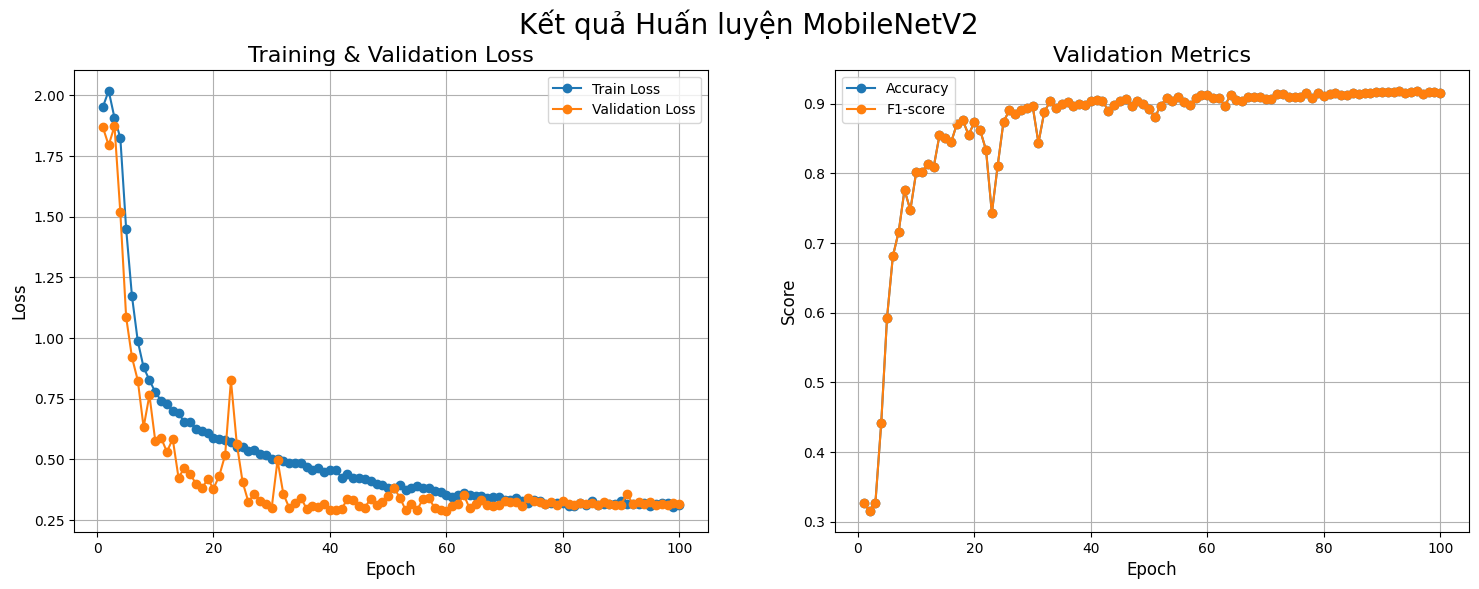


Tải trọng số model tốt nhất để vẽ Confusion Matrix.


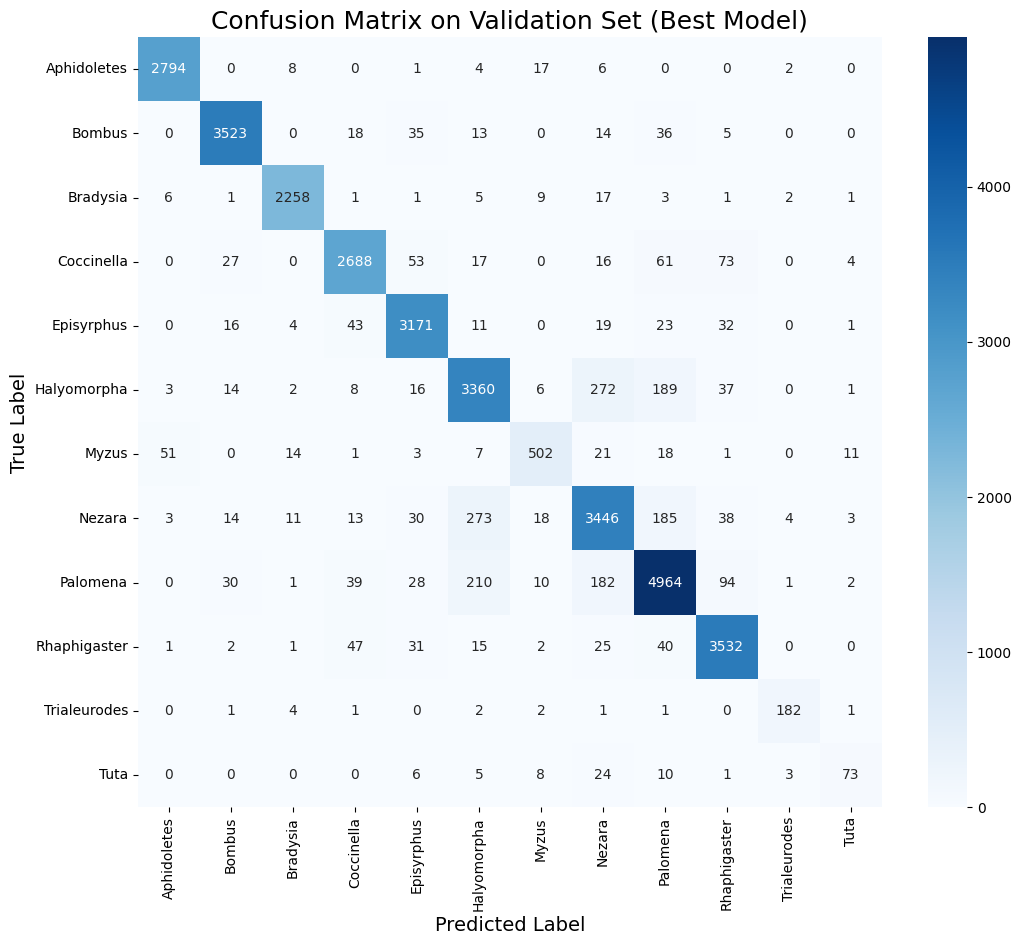

In [13]:
log_df = pd.read_csv(LOG_CSV_PATH)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

ax1.plot(log_df['epoch'], log_df['train_loss'], label='Train Loss', marker='o')
ax1.plot(log_df['epoch'], log_df['val_loss'], label='Validation Loss', marker='o')
ax1.set_title('Training & Validation Loss', fontsize=16)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.legend()
ax1.grid(True)

ax2.plot(log_df['epoch'], log_df['accuracy'], label='Accuracy', marker='o')
ax2.plot(log_df['epoch'], log_df['f1'], label='F1-score', marker='o')
ax2.set_title('Validation Metrics', fontsize=16)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Score', fontsize=12)
ax2.legend()
ax2.grid(True)

plt.suptitle('Kết quả Huấn luyện MobileNetV2', fontsize=20)
plt.show()

best_model_path = os.path.join(CHECKPOINT_DIR, 'best_model.pth')
if os.path.exists(best_model_path):
    model.load_state_dict(torch.load(best_model_path, map_location=device))
    print("\nTải trọng số model tốt nhất để vẽ Confusion Matrix.")

model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for inputs, labels in val_loader:
        if -1 in labels: continue
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=full_dataset.class_names,
            yticklabels=full_dataset.class_names)
plt.title('Confusion Matrix on Validation Set (Best Model)', fontsize=18)
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.show()
